In [37]:
import sys
# sys.path.append('/content/ML_Forex_Forecasting')
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import mean_squared_error
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.statespace.tools import diff
import pickle
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

# Load the Data

In [19]:
usd_eur = pd.read_csv("./USDEUR=X.csv", parse_dates=['Date'])
usd_eur = usd_eur[['Date', 'Close']]

gold_prices = pd.read_csv("./GC=F.csv", parse_dates=['Date'])
gold_prices = gold_prices[['Date', 'Close']]
gold_prices.rename(columns = {'Close':'Gold_Price'}, inplace = True)

GSPC = pd.read_csv("./GSPC.csv", parse_dates=['Date'])
GSPC = GSPC[['Date', 'Close']]
GSPC.rename(columns = {'Close':'GSPC'}, inplace = True)

S50 = pd.read_csv("./STOXX50E.csv", parse_dates=['Date'])
S50 = S50[['Date', 'Close']]
S50.rename(columns = {'Close':'S50'}, inplace = True)

usd_eur = usd_eur.merge(gold_prices, on='Date')
usd_eur = usd_eur.merge(S50, on='Date')
usd_eur = usd_eur.merge(GSPC, on='Date')

print(f"USD/EUR: {usd_eur.shape}")
display(usd_eur.head(20))

USD/EUR: (248, 5)


,Date,Close,Gold_Price,S50,GSPC
0,2022-11-30,0.96857,1746.000000,3964.719971,4080.110107
1,2022-12-01,0.95920,1801.099976,3984.500000,4076.570068
2,2022-12-02,0.94981,1795.900024,3977.899902,4071.699951
3,2022-12-05,0.94839,1767.400024,3956.530029,3998.840088
4,2022-12-06,0.95266,1769.300049,3939.189941,3941.260010
5,2022-12-07,0.95520,1785.500000,3920.899902,3933.919922
6,2022-12-08,0.95118,1788.699951,3921.270020,3963.510010
7,2022-12-09,0.94700,1798.099976,3942.620117,3934.379883
8,2022-12-12,0.95037,1780.500000,3921.820068,3990.560059
9,2022-12-13,0.94861,1813.900024,3986.830078,4019.649902


## Dickey-Fuller Test

In [7]:
def dickey_fuller_test(df,var):
    result = adfuller(df[var].values)
    #Extracting the values from the results:
    print(f"Dickey-Fuller test for feature: {var}")

    print('Test Statistic: %f' % result[0])

    print('p-value: %f' % result[1])

    print('Critical Values:')

    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[0] < result[4]["5%"]:
        print ("Reject H0 - Time Series is Stationary")
    else:
        print ("Failed to Reject H0 - Time Series is Non-Stationary")

In [22]:
dickey_fuller_test(usd_eur,'Close')
print("")
dickey_fuller_test(usd_eur,'Gold_Price')
print("")
dickey_fuller_test(usd_eur,'S50')
print("")
dickey_fuller_test(usd_eur,'GSPC')

Dickey-Fuller test for feature: Close
Test Statistic: -3.132180
p-value: 0.024262
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
Reject H0 - Time Series is Stationary

Dickey-Fuller test for feature: Gold_Price
Test Statistic: -2.685278
p-value: 0.076621
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573
Failed to Reject H0 - Time Series is Non-Stationary

Dickey-Fuller test for feature: S50
Test Statistic: -2.412376
p-value: 0.138274
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
Failed to Reject H0 - Time Series is Non-Stationary

Dickey-Fuller test for feature: GSPC
Test Statistic: -0.958196
p-value: 0.768204
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
Failed to Reject H0 - Time Series is Non-Stationary


In [30]:
# Perform differencing
diff_data = diff(usd_eur.set_index('Date'), k_diff=1)

In [31]:
dickey_fuller_test(diff_data,'Close')
print("")
dickey_fuller_test(diff_data,'Gold_Price')
print("")
dickey_fuller_test(diff_data,'S50')
print("")
dickey_fuller_test(diff_data,'GSPC')

Dickey-Fuller test for feature: Close
Test Statistic: -13.048003
p-value: 0.000000
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
Reject H0 - Time Series is Stationary

Dickey-Fuller test for feature: Gold_Price
Test Statistic: -4.766397
p-value: 0.000063
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573
Reject H0 - Time Series is Stationary

Dickey-Fuller test for feature: S50
Test Statistic: -7.772308
p-value: 0.000000
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573
Reject H0 - Time Series is Stationary

Dickey-Fuller test for feature: GSPC
Test Statistic: -14.923821
p-value: 0.000000
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
Reject H0 - Time Series is Stationary


# Autocorrelograms

In [39]:
def plot_autocorrelograms(df,var):
    ACF = plot_acf(df[var].dropna(),lags=20)
    plt.title(f"Autocorrelation for {var}")
    PACF = plot_pacf(df[var].dropna(),lags=20)
    plt.title(f"Partial Autocorrelation for {var}")

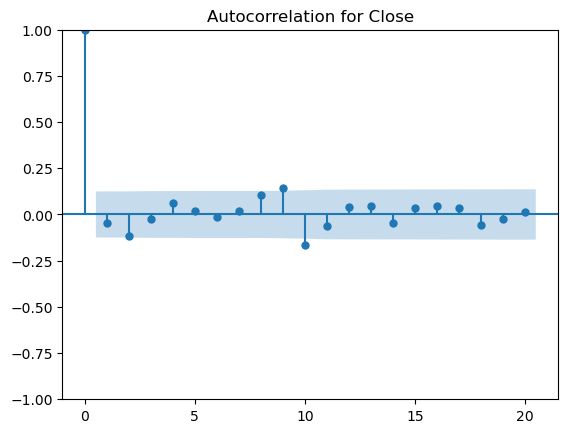

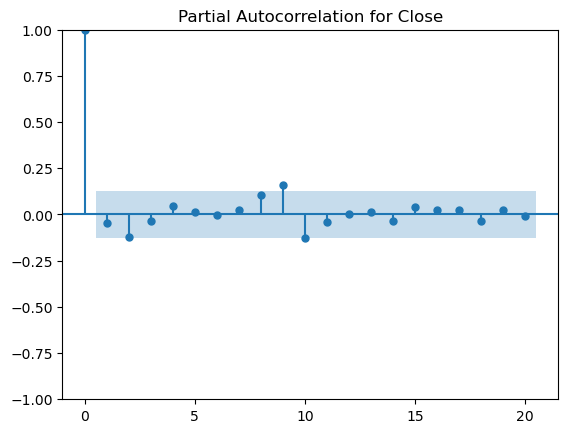

In [44]:
plot_autocorrelograms(diff_data,'Close')

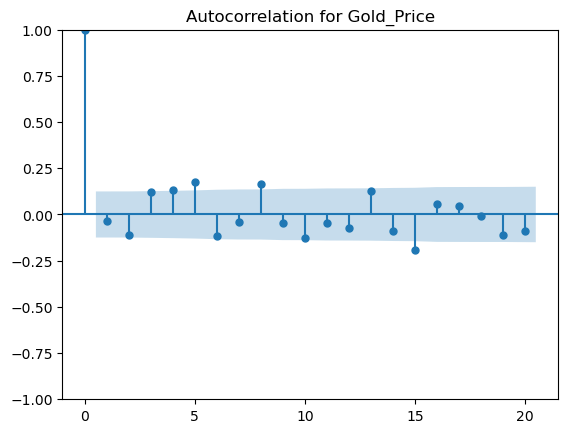

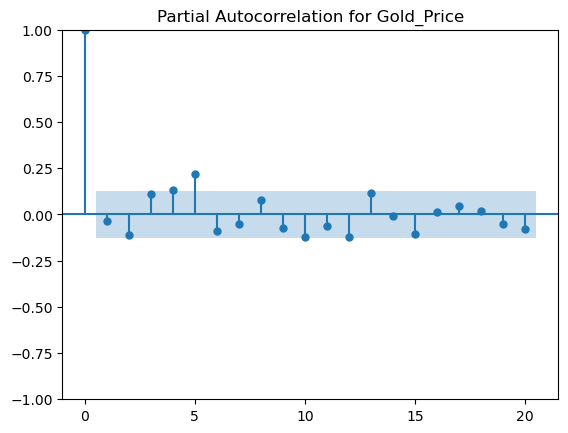

In [46]:
plot_autocorrelograms(diff_data,'Gold_Price')

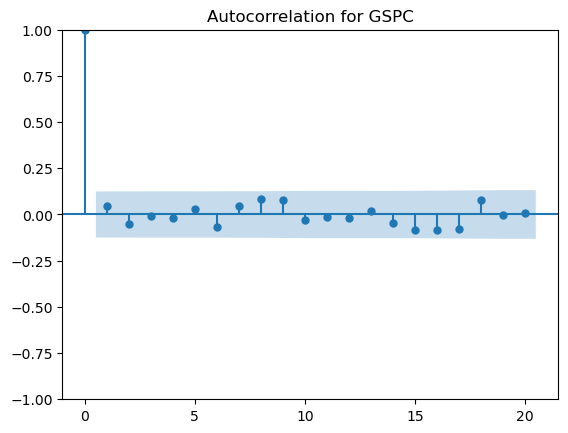

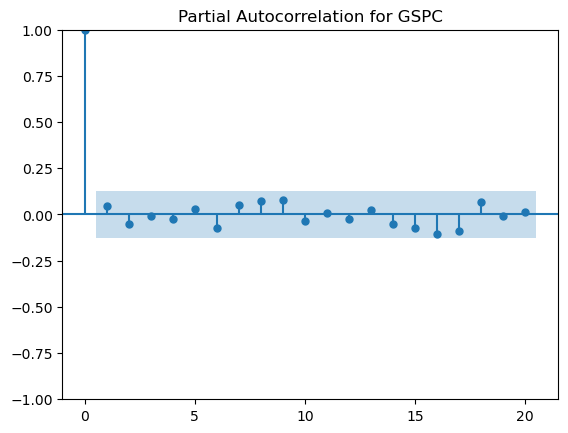

In [47]:
plot_autocorrelograms(diff_data,'GSPC')

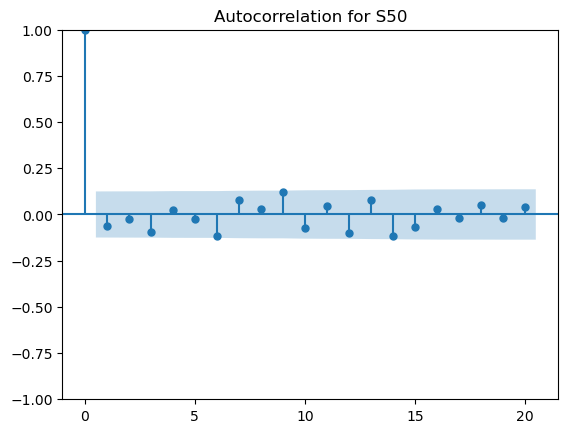

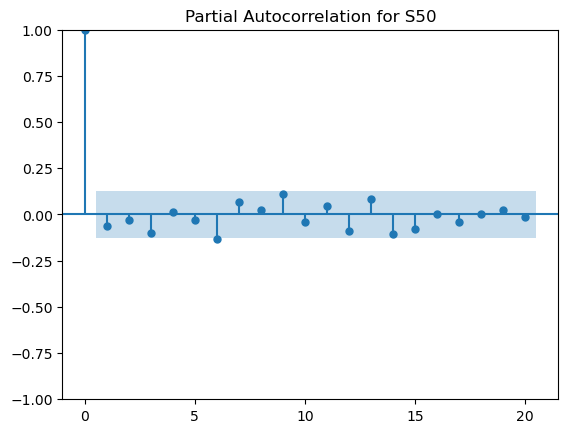

In [48]:
plot_autocorrelograms(diff_data,'S50')

# Model Training

In [67]:
data = usd_eur.copy()
df = data.dropna()

# train_size = int(len(df) * 0.8)
# train, test = df[:train_size], df[train_size:]
train, test = df[:-5], df[-5:]

data = train[['Close','Gold_Price','S50','GSPC']]

diff_data = diff(data, k_diff=1)
diff_test = diff(df[-6:], k_diff=1)

p = np.arange(5,11)
q = np.arange(5,11)
models = []
orders = []
MSEs = []
for i in p:
    for j in q:
        orders.append((i,j))
        model = VARMAX(endog=diff_data[['Close','Gold_Price']], order=(i,j), mle_regression = True, filter_concentrated = True, initialization='approximate_diffuse', exog=diff_data[['S50','GSPC']])
        model_fit = model.fit(disp=False)
        pred = pd.DataFrame()
        pred['prediction'] = data.iloc[-1]['Close'] + model_fit.forecast(5, exog=diff_test[['S50','GSPC']]).reset_index(drop=True).Close
        pred['observed'] = test.reset_index(drop=True).Close
        models.append(model_fit)
        MSEs.append(np.mean((pred['prediction'].values-pred['observed'].values)**2))
        # pickle.dump(model_fit, open(f"./usd_eur_models/model_{i}_{j}_best.pkl","wb"))

In [72]:
idx = np.argmin(MSEs)
print(orders[idx])
model_fit = models[idx]

(9, 9)


Text(0.5, 1.0, 'MSE = 5.702073812251513e-06')

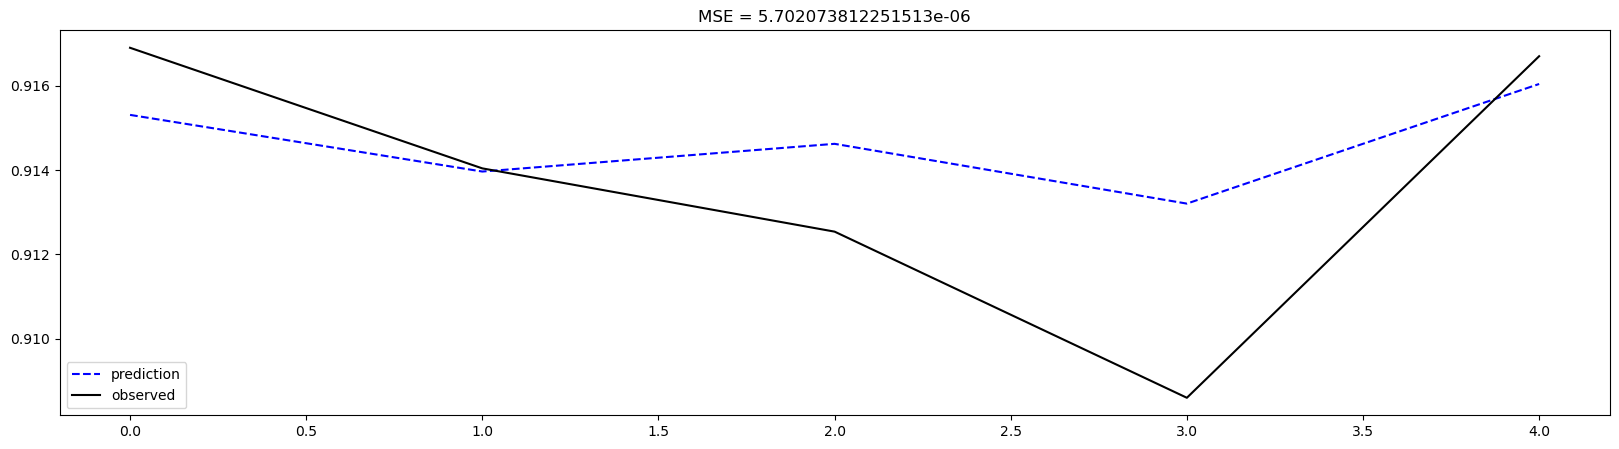

In [73]:
# plot prediction vs observed
pred = pd.DataFrame()
pred['prediction'] = data.iloc[-1]['Close'] + model_fit.forecast(5, exog=diff_test[['S50','GSPC']]).reset_index(drop=True).Close
pred['observed'] = test.reset_index(drop=True).Close

pred.plot(figsize=(20,5),title='prediction vs observed',color=['blue','black'],style=['--','-'])
plt.title(f"MSE = {np.mean((pred['prediction'].values-pred['observed'].values)**2)}")

In [74]:
print(pred)

   prediction  observed
0    0.915309   0.91690
1    0.913965   0.91404
2    0.914622   0.91254
3    0.913205   0.90860
4    0.916041   0.91670


In [75]:
import pickle
pickle.dump(model_fit, open("./usd_eur_models/model_9_9_best.pkl","wb"))